8f0e8a736b88b035e4f17a409195c60e25db00e9

In [ ]:
import torch
from datasets import Dataset
import pandas as pd
from sklearn.metrics import classification_report
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import evaluate

# Load and preprocess data
data = pd.read_csv('C:/ENIAD/2emeAnne/Machine Learning/Project/balanced_subset.csv')

# Sample 30% of the data for faster experimentation
sampled_data = data.sample(frac=0.3, random_state=42)
sampled_data['rating'] = sampled_data['rating'].map({"Positive": 2, "Neutral": 1, "Negative": 0})

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    sampled_data['cleaned_text'].tolist(), sampled_data['rating'].tolist(), test_size=0.2, random_state=42
)

# Tokenize using Hugging Face tokenizer and load them directly into datasets
model_name = "xlnet-base-cased"
tokenizer = XLNetTokenizer.from_pretrained(model_name)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Create dataset for Hugging Face Trainer
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels,
})

val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels,
})

# Load model and move it to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {'GPU' if torch.cuda.is_available() else 'CPU'}")

model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)



# Modify compute_metrics function to include classification_report
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), axis=-1)

    # Convert tensors to numpy arrays for classification_report
    predictions = predictions.cpu().numpy()


    # Generate classification report
    report = classification_report(labels, predictions, output_dict=True)

    # Optionally, you can extract the accuracy or any other metric
    accuracy = report['accuracy']

    return {
        'accuracy': accuracy,
        'report': report
    }

# Training arguments for optimized training
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,  # Experiment with batch size
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_dir="./logs",
    logging_steps=1000,
    fp16=True,  # Enable mixed precision for faster computation
    dataloader_num_workers=4,  # Parallelize data loading
    gradient_accumulation_steps=2,  # Accumulate gradients over two steps
)

# Initialize the optimizer (AdamW)
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)

# Create a learning rate scheduler (Linear with warmup)
num_training_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,  # You can increase this for smoother warmup
    num_training_steps=num_training_steps
)

# Initialize Trainer with the custom optimizer and scheduler
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler),  # Add the optimizer and scheduler here
)

# Start training
trainer.train()

# Save the fine-tuned model
try:

    model.save_pretrained("C:/ENIAD/2emeAnne/Machine Learning/Project/xlnet_model")
    tokenizer.save_pretrained("C:/ENIAD/2emeAnne/Machine Learning/Project/xlnet_model")

except OSError as e:
    print(f"Error: {e}")

c:\Users\amine\anaconda3\envs\cuda_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\amine\anaconda3\envs\cuda_env\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\amine\anaconda3\envs\cuda_env\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\amine\AppData\Local\Temp\ipykernel_10276\1357459107.py:102

{'loss': 0.6113, 'grad_norm': 9.395654678344727, 'learning_rate': 2.9790053540562952e-05, 'epoch': 0.08}


  6%|▌         | 2000/35832 [07:44<2:07:12,  4.43it/s]

{'loss': 0.4777, 'grad_norm': 20.857141494750977, 'learning_rate': 2.9368474304745575e-05, 'epoch': 0.17}


  8%|▊         | 3000/35832 [11:27<2:02:25,  4.47it/s]

{'loss': 0.4482, 'grad_norm': 7.249002933502197, 'learning_rate': 2.8946895068928206e-05, 'epoch': 0.25}


 11%|█         | 4000/35832 [15:11<1:59:46,  4.43it/s]

{'loss': 0.4391, 'grad_norm': 6.493470191955566, 'learning_rate': 2.8525315833110833e-05, 'epoch': 0.33}


 14%|█▍        | 5000/35832 [18:54<1:54:07,  4.50it/s]

{'loss': 0.4331, 'grad_norm': 9.719244956970215, 'learning_rate': 2.8104158176529282e-05, 'epoch': 0.42}


 17%|█▋        | 6000/35832 [22:38<1:51:09,  4.47it/s]

{'loss': 0.4275, 'grad_norm': 10.435176849365234, 'learning_rate': 2.7682578940711906e-05, 'epoch': 0.5}


 20%|█▉        | 7000/35832 [26:21<1:46:58,  4.49it/s]

{'loss': 0.4273, 'grad_norm': 6.275691986083984, 'learning_rate': 2.7261421284130352e-05, 'epoch': 0.59}


 22%|██▏       | 8000/35832 [30:04<1:42:50,  4.51it/s]

{'loss': 0.415, 'grad_norm': 8.732362747192383, 'learning_rate': 2.6839842048312982e-05, 'epoch': 0.67}


 25%|██▌       | 9000/35832 [33:47<1:40:39,  4.44it/s]

{'loss': 0.4115, 'grad_norm': 9.159427642822266, 'learning_rate': 2.6418684391731425e-05, 'epoch': 0.75}


 28%|██▊       | 10000/35832 [37:30<1:34:55,  4.54it/s]

{'loss': 0.4039, 'grad_norm': 6.571773529052734, 'learning_rate': 2.5997105155914055e-05, 'epoch': 0.84}


 31%|███       | 11000/35832 [41:13<1:33:19,  4.43it/s]

{'loss': 0.4118, 'grad_norm': 5.822977542877197, 'learning_rate': 2.55759474993325e-05, 'epoch': 0.92}


 33%|███▎      | 11944/35832 [44:44<3:30:07,  1.89it/s]Trainer is attempting to log a value of "{'0': {'precision': 0.9107220887043915, 'recall': 0.852820827579152, 'f1-score': 0.8808209408595051, 'support': 39102.0}, '1': {'precision': 0.5834879406307978, 'recall': 0.6476375700720741, 'f1-score': 0.6138914493303692, 'support': 17482.0}, '2': {'precision': 0.8934706165093982, 'recall': 0.9064031823431284, 'f1-score': 0.8998904374856677, 'support': 38965.0}, 'accuracy': 0.8371306868727041, 'macro avg': {'precision': 0.7958935486148624, 'recall': 0.8022871933314516, 'f1-score': 0.798200942558514, 'support': 95549.0}, 'weighted avg': {'precision': 0.8438149416834863, 'recall': 0.8371306868727041, 'f1-score': 0.8397590936934026, 'support': 95549.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                       
 33%|███▎      | 11944/35832 [48:

{'eval_loss': 0.396684855222702, 'eval_accuracy': 0.8371306868727041, 'eval_report': {'0': {'precision': 0.9107220887043915, 'recall': 0.852820827579152, 'f1-score': 0.8808209408595051, 'support': 39102.0}, '1': {'precision': 0.5834879406307978, 'recall': 0.6476375700720741, 'f1-score': 0.6138914493303692, 'support': 17482.0}, '2': {'precision': 0.8934706165093982, 'recall': 0.9064031823431284, 'f1-score': 0.8998904374856677, 'support': 38965.0}, 'accuracy': 0.8371306868727041, 'macro avg': {'precision': 0.7958935486148624, 'recall': 0.8022871933314516, 'f1-score': 0.798200942558514, 'support': 95549.0}, 'weighted avg': {'precision': 0.8438149416834863, 'recall': 0.8371306868727041, 'f1-score': 0.8397590936934026, 'support': 95549.0}}, 'eval_runtime': 230.3633, 'eval_samples_per_second': 414.775, 'eval_steps_per_second': 25.924, 'epoch': 1.0}


 33%|███▎      | 12000/35832 [49:04<1:28:26,  4.49it/s]  

{'loss': 0.4046, 'grad_norm': 8.049540519714355, 'learning_rate': 2.5154789842750943e-05, 'epoch': 1.0}


 36%|███▋      | 13000/35832 [52:47<1:25:14,  4.46it/s]

{'loss': 0.3598, 'grad_norm': 9.124106407165527, 'learning_rate': 2.4733210606933574e-05, 'epoch': 1.09}


 39%|███▉      | 14000/35832 [56:30<1:21:36,  4.46it/s]

{'loss': 0.3668, 'grad_norm': 11.35982608795166, 'learning_rate': 2.4311631371116204e-05, 'epoch': 1.17}


 42%|████▏     | 15000/35832 [1:00:14<1:17:44,  4.47it/s]

{'loss': 0.363, 'grad_norm': 7.901259422302246, 'learning_rate': 2.3890052135298828e-05, 'epoch': 1.26}


 45%|████▍     | 16000/35832 [1:03:57<1:13:23,  4.50it/s]

{'loss': 0.3626, 'grad_norm': 9.914389610290527, 'learning_rate': 2.3468894478717274e-05, 'epoch': 1.34}


 47%|████▋     | 17000/35832 [1:07:41<1:09:44,  4.50it/s]

{'loss': 0.3687, 'grad_norm': 7.191378593444824, 'learning_rate': 2.3047315242899904e-05, 'epoch': 1.42}


 50%|█████     | 18000/35832 [1:11:24<1:07:21,  4.41it/s]

{'loss': 0.3678, 'grad_norm': 8.997838020324707, 'learning_rate': 2.262573600708253e-05, 'epoch': 1.51}


 53%|█████▎    | 19000/35832 [1:15:07<1:02:12,  4.51it/s]

{'loss': 0.3567, 'grad_norm': 11.209043502807617, 'learning_rate': 2.2204578350500977e-05, 'epoch': 1.59}


 56%|█████▌    | 20000/35832 [1:18:51<58:37,  4.50it/s]  

{'loss': 0.3655, 'grad_norm': 11.002943992614746, 'learning_rate': 2.1782999114683608e-05, 'epoch': 1.67}


 59%|█████▊    | 21000/35832 [1:22:34<55:27,  4.46it/s]

{'loss': 0.3593, 'grad_norm': 12.585968017578125, 'learning_rate': 2.136184145810205e-05, 'epoch': 1.76}


 61%|██████▏   | 22000/35832 [1:26:17<51:05,  4.51it/s]

{'loss': 0.359, 'grad_norm': 5.086315155029297, 'learning_rate': 2.0940262222284677e-05, 'epoch': 1.84}


 64%|██████▍   | 23000/35832 [1:30:00<47:24,  4.51it/s]

{'loss': 0.3596, 'grad_norm': 8.160648345947266, 'learning_rate': 2.0519104565703126e-05, 'epoch': 1.93}


 67%|██████▋   | 23888/35832 [1:33:20<1:39:28,  2.00it/s]Trainer is attempting to log a value of "{'0': {'precision': 0.8979304225278597, 'recall': 0.8799038412357424, 'f1-score': 0.8888257404513105, 'support': 39102.0}, '1': {'precision': 0.6024729182623919, 'recall': 0.6299050451893377, 'f1-score': 0.6158836689038032, 'support': 17482.0}, '2': {'precision': 0.9052215433588335, 'recall': 0.904965995123829, 'f1-score': 0.9050937512031726, 'support': 38965.0}, 'accuracy': 0.8443835100315021, 'macro avg': {'precision': 0.8018749613830284, 'recall': 0.804924960516303, 'f1-score': 0.8032677201860955, 'support': 95549.0}, 'weighted avg': {'precision': 0.8468457480007583, 'recall': 0.8443835100315021, 'f1-score': 0.845521359915175, 'support': 95549.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                         
 67%|██████▋   | 23888/35832 [

{'eval_loss': 0.3791871964931488, 'eval_accuracy': 0.8443835100315021, 'eval_report': {'0': {'precision': 0.8979304225278597, 'recall': 0.8799038412357424, 'f1-score': 0.8888257404513105, 'support': 39102.0}, '1': {'precision': 0.6024729182623919, 'recall': 0.6299050451893377, 'f1-score': 0.6158836689038032, 'support': 17482.0}, '2': {'precision': 0.9052215433588335, 'recall': 0.904965995123829, 'f1-score': 0.9050937512031726, 'support': 38965.0}, 'accuracy': 0.8443835100315021, 'macro avg': {'precision': 0.8018749613830284, 'recall': 0.804924960516303, 'f1-score': 0.8032677201860955, 'support': 95549.0}, 'weighted avg': {'precision': 0.8468457480007583, 'recall': 0.8443835100315021, 'f1-score': 0.845521359915175, 'support': 95549.0}}, 'eval_runtime': 229.9746, 'eval_samples_per_second': 415.476, 'eval_steps_per_second': 25.968, 'epoch': 2.0}


 67%|██████▋   | 24000/35832 [1:37:51<43:53,  4.49it/s]    

{'loss': 0.3596, 'grad_norm': 4.107089519500732, 'learning_rate': 2.0097525329885754e-05, 'epoch': 2.01}


 70%|██████▉   | 25000/35832 [1:41:35<40:22,  4.47it/s]

{'loss': 0.3017, 'grad_norm': 6.894366264343262, 'learning_rate': 1.967594609406838e-05, 'epoch': 2.09}


 73%|███████▎  | 26000/35832 [1:45:18<36:59,  4.43it/s]

{'loss': 0.3071, 'grad_norm': 12.321025848388672, 'learning_rate': 1.9254788437486826e-05, 'epoch': 2.18}


 75%|███████▌  | 27000/35832 [1:49:01<32:59,  4.46it/s]

{'loss': 0.3135, 'grad_norm': 11.214513778686523, 'learning_rate': 1.8833209201669457e-05, 'epoch': 2.26}


 78%|███████▊  | 28000/35832 [1:52:45<29:07,  4.48it/s]

{'loss': 0.3153, 'grad_norm': 12.243853569030762, 'learning_rate': 1.84120515450879e-05, 'epoch': 2.34}


 81%|████████  | 29000/35832 [1:56:28<25:10,  4.52it/s]

{'loss': 0.3114, 'grad_norm': 9.857990264892578, 'learning_rate': 1.7990472309270526e-05, 'epoch': 2.43}


 84%|████████▎ | 30000/35832 [2:00:11<22:01,  4.41it/s]

{'loss': 0.3115, 'grad_norm': 8.269617080688477, 'learning_rate': 1.7569314652688976e-05, 'epoch': 2.51}


 87%|████████▋ | 31000/35832 [2:03:55<18:01,  4.47it/s]

{'loss': 0.3104, 'grad_norm': 9.019610404968262, 'learning_rate': 1.71477354168716e-05, 'epoch': 2.6}


 89%|████████▉ | 32000/35832 [2:07:38<14:13,  4.49it/s]

{'loss': 0.3155, 'grad_norm': 5.443750381469727, 'learning_rate': 1.672657776029005e-05, 'epoch': 2.68}


 92%|█████████▏| 33000/35832 [2:11:22<10:31,  4.48it/s]

{'loss': 0.3151, 'grad_norm': 14.933924674987793, 'learning_rate': 1.6305420103708494e-05, 'epoch': 2.76}


 95%|█████████▍| 34000/35832 [2:15:06<06:50,  4.47it/s]

{'loss': 0.315, 'grad_norm': 8.461066246032715, 'learning_rate': 1.5883840867891118e-05, 'epoch': 2.85}


 98%|█████████▊| 35000/35832 [2:18:49<03:06,  4.45it/s]

{'loss': 0.3156, 'grad_norm': 4.8053154945373535, 'learning_rate': 1.5462683211309567e-05, 'epoch': 2.93}


100%|██████████| 35832/35832 [2:21:57<00:00,  1.40it/s]Trainer is attempting to log a value of "{'0': {'precision': 0.8852586835685002, 'recall': 0.9001329855250371, 'f1-score': 0.8926338747923562, 'support': 39102.0}, '1': {'precision': 0.6262009789111125, 'recall': 0.5927811463219311, 'f1-score': 0.6090329405542007, 'support': 17482.0}, '2': {'precision': 0.9042328177161643, 'recall': 0.9106377518285641, 'f1-score': 0.9074239828146179, 'support': 38965.0}, 'accuracy': 0.8481826078765868, 'macro avg': {'precision': 0.8052308267319258, 'recall': 0.8011839612251775, 'f1-score': 0.803030266053725, 'support': 95549.0}, 'weighted avg': {'precision': 0.8455981988354657, 'recall': 0.8481826078765868, 'f1-score': 0.8467766185859699, 'support': 95549.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                       
100%|██████████| 35832/35832 [2:

{'eval_loss': 0.40848806500434875, 'eval_accuracy': 0.8481826078765868, 'eval_report': {'0': {'precision': 0.8852586835685002, 'recall': 0.9001329855250371, 'f1-score': 0.8926338747923562, 'support': 39102.0}, '1': {'precision': 0.6262009789111125, 'recall': 0.5927811463219311, 'f1-score': 0.6090329405542007, 'support': 17482.0}, '2': {'precision': 0.9042328177161643, 'recall': 0.9106377518285641, 'f1-score': 0.9074239828146179, 'support': 38965.0}, 'accuracy': 0.8481826078765868, 'macro avg': {'precision': 0.8052308267319258, 'recall': 0.8011839612251775, 'f1-score': 0.803030266053725, 'support': 95549.0}, 'weighted avg': {'precision': 0.8455981988354657, 'recall': 0.8481826078765868, 'f1-score': 0.8467766185859699, 'support': 95549.0}}, 'eval_runtime': 232.2098, 'eval_samples_per_second': 411.477, 'eval_steps_per_second': 25.718, 'epoch': 3.0}


100%|██████████| 35832/35832 [2:25:52<00:00,  4.09it/s]


{'train_runtime': 8752.9729, 'train_samples_per_second': 130.994, 'train_steps_per_second': 4.094, 'train_loss': 0.37263918529799217, 'epoch': 3.0}


Comparaison

In [ ]:
import torch
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification
from peft import PeftModel, PeftConfig
from sklearn.model_selection import train_test_split

# Set device to GPU or CPU depending on availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load previously saved models and vectorizers
LR_model = joblib.load('/content/drive/MyDrive/Machine Learning/Logistic Regression/logreg_model.pkl')
svm_model = joblib.load('/content/drive/MyDrive/Machine Learning/SVM/svm_model.pkl')
LR_vectorizer = joblib.load('/content/drive/MyDrive/Machine Learning/Logistic Regression/tfidf_vectorizer.pkl')
SVM_vectorizer = joblib.load('/content/drive/MyDrive/Machine Learning/SVM/tfidf_vectorizer.pkl')

loaded_label_encoder = joblib.load('/content/drive/MyDrive/Machine Learning/Logistic Regression/label_encoder.pkl')

# Load the transformers models (already fine-tuned)
Bert_model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Machine Learning/fine_tuned_BERT",num_labels=3).to(device)
Bert_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Machine Learning/fine_tuned_BERT")

Xlnet_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Machine Learning/xlnet_model").to(device)
Xlnet_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Machine Learning/xlnet_model")

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/Machine Learning/balanced_subset.csv')

# Randomly sample 10,000 lines from the dataset
sampled_data = data.sample(n=10000, random_state=42)

# Assuming 'text' is the column with your text data and 'label' is the column with your labels
X_val = sampled_data.iloc[:,1]
y_val = sampled_data.iloc[:,0]

# Function to make predictions using the Logistic Regression model
def predict_lr_model(X):
    X_vectorized = LR_vectorizer.transform(X)
    return LR_model.predict(X_vectorized)

# Function to make predictions using the SVM model
def predict_svm_model(X):
    X_vectorized = SVM_vectorizer.transform(X)
    return svm_model.predict(X_vectorized)

# Function to make predictions using the BERT model
def predict_bert_model(X,batch_size=32):
    predictions = []
    for i in range(0, len(X), batch_size):
        batch = X[i:i+batch_size]
        inputs = Bert_tokenizer(batch.tolist(), padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)
        with torch.no_grad():
            outputs = Bert_model(**inputs)
        predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
    return np.array(predictions)

# Function to make predictions using the XLNet model
def predict_xlnet_model(X,batch_size=32):
    predictions = []
    for i in range(0, len(X), batch_size):
        batch = X[i:i+batch_size]
        inputs = Xlnet_tokenizer(batch.tolist(), padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)
        with torch.no_grad():
            outputs = Xlnet_model(**inputs)
        predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
    return np.array(predictions)

# Make predictions for each model
lr_preds = predict_lr_model(X_val)
svm_preds = predict_svm_model(X_val)
bert_preds = predict_bert_model(X_val)
xlnet_preds = predict_xlnet_model(X_val)

# Decode label predictions if necessary
decoded_lr_preds = loaded_label_encoder.inverse_transform(lr_preds)
decoded_bert_preds = loaded_label_encoder.inverse_transform(bert_preds)
decoded_xlnet_preds = loaded_label_encoder.inverse_transform(xlnet_preds)

# Evaluate and compare performance
print("Logistic Regression Performance:")
print(classification_report(y_val, decoded_lr_preds))

print("\nSVM Performance:")
print(classification_report(y_val, svm_preds))

print("\nBERT Performance:")
print(classification_report(y_val, decoded_bert_preds))

print("\nXLNet Performance:")
print(classification_report(y_val, decoded_xlnet_preds))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.2 when using version 1.6.0. This might lead to breaking code or inval

Logistic Regression Performance:
              precision    recall  f1-score   support

    Negative       0.86      0.87      0.86      4050
     Neutral       0.58      0.50      0.53      1842
    Positive       0.85      0.90      0.87      4108

    accuracy                           0.81     10000
   macro avg       0.76      0.75      0.76     10000
weighted avg       0.81      0.81      0.81     10000


SVM Performance:
              precision    recall  f1-score   support

    Negative       0.89      0.95      0.92      4050
     Neutral       0.85      0.67      0.74      1842
    Positive       0.91      0.94      0.92      4108

    accuracy                           0.89     10000
   macro avg       0.88      0.85      0.86     10000
weighted avg       0.89      0.89      0.89     10000


BERT Performance:
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87      4050
     Neutral       0.59      0.50      0.54      1842
    P

Logistic Regression - Precision: 0.81, Recall: 0.81, F1-Score: 0.81


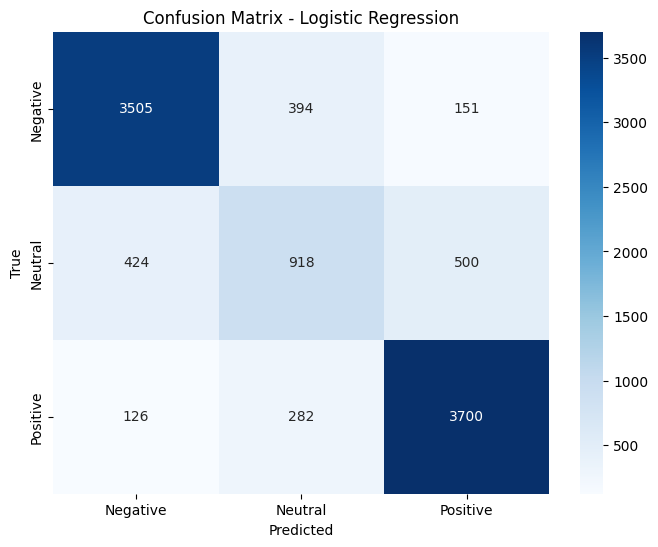

SVM - Precision: 0.89, Recall: 0.89, F1-Score: 0.89


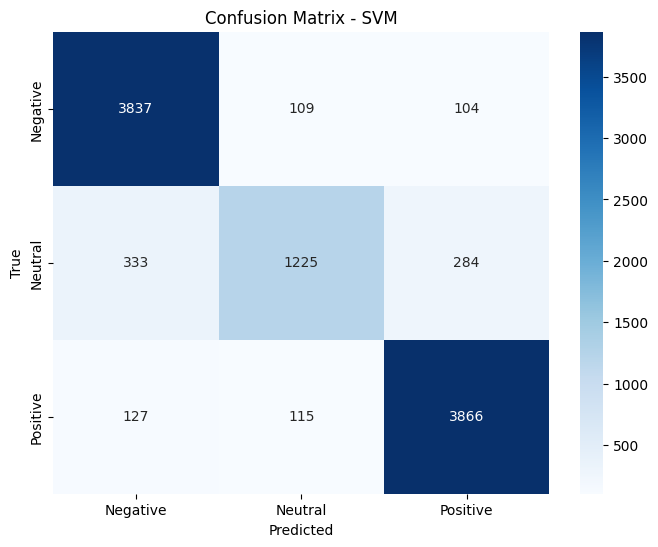

BERT - Precision: 0.82, Recall: 0.82, F1-Score: 0.82


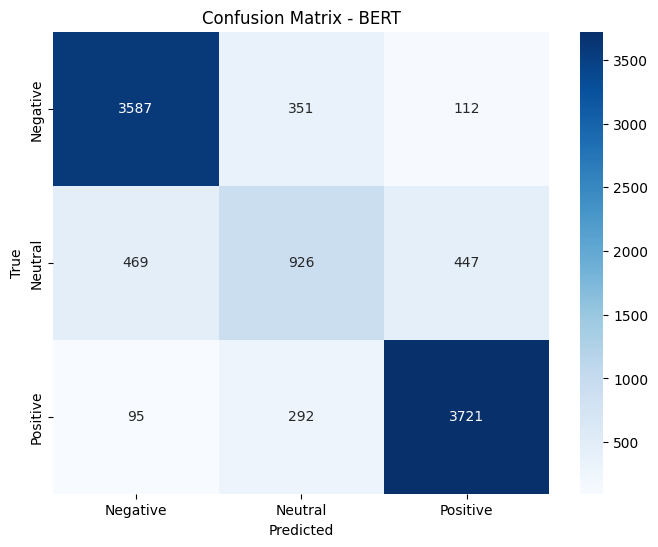

XLNet - Precision: 0.88, Recall: 0.88, F1-Score: 0.88


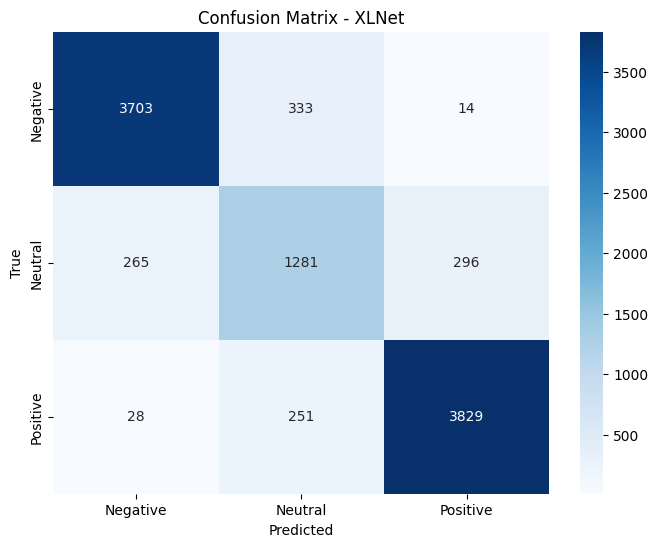

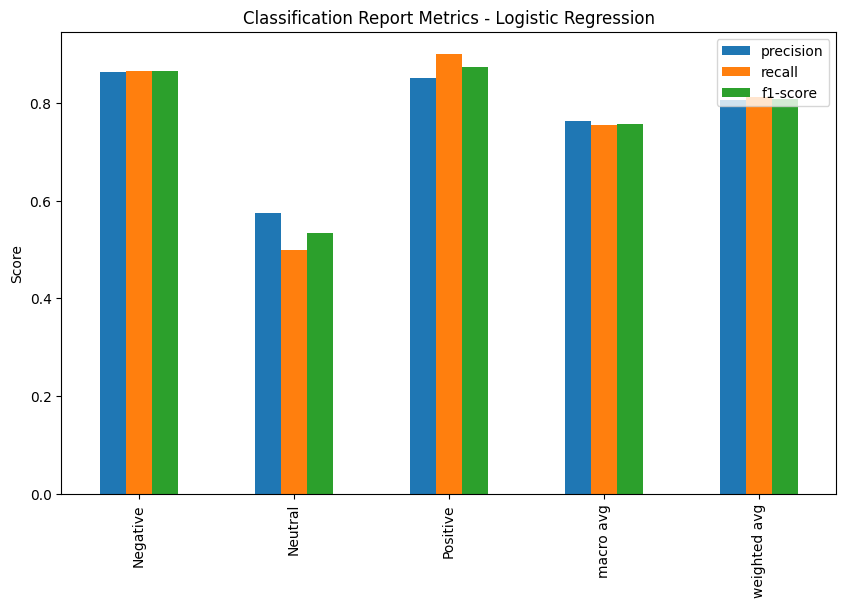

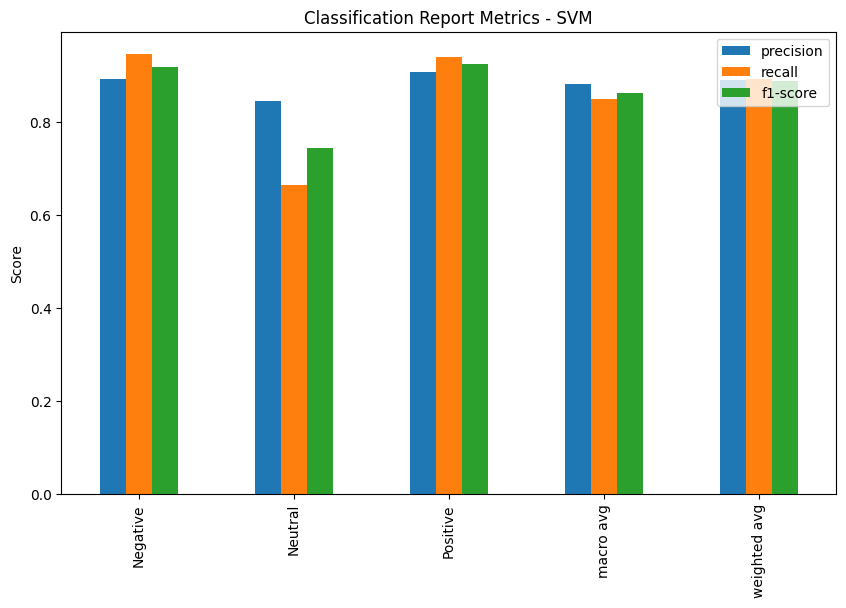

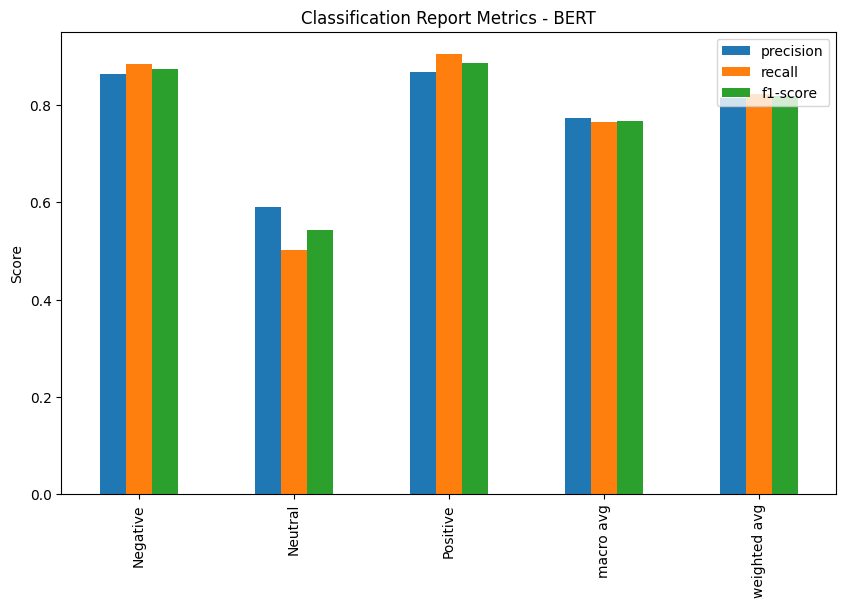

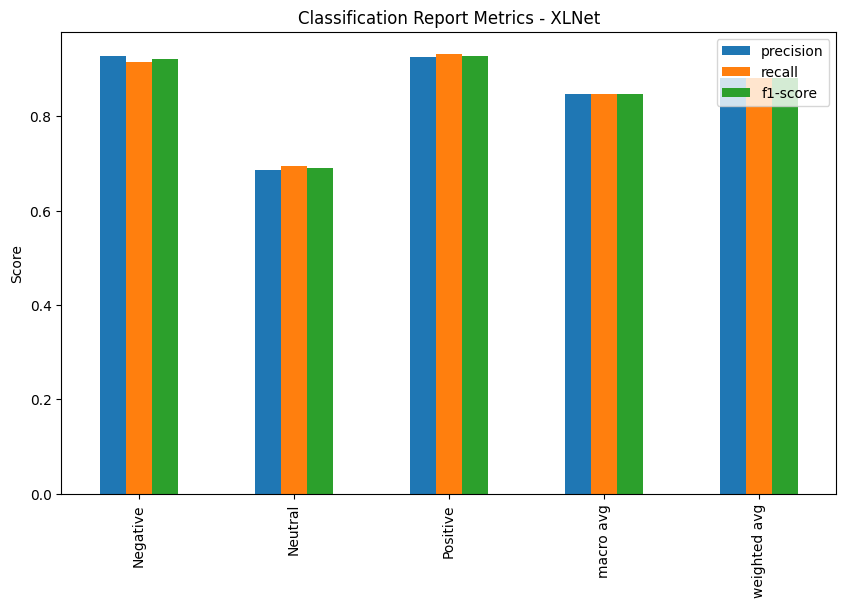

<ipython-input-38-df4a34144772>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


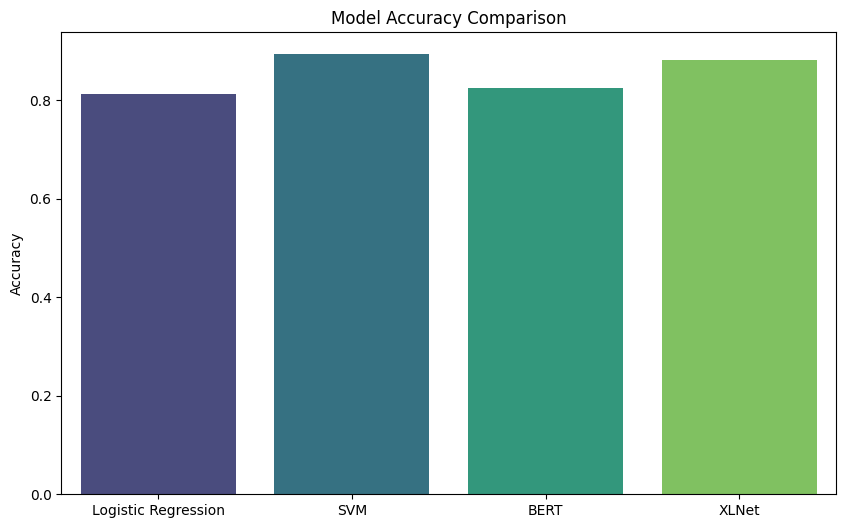

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve,precision_score,recall_score, f1_score
from sklearn.metrics import accuracy_score
import numpy as np


# Create confusion matrix for each model
def plot_confusion_matrix_and_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    # Compute additional metrics
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"{model_name} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot classification report (Precision, Recall, F1-score) comparison
def plot_classification_report(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    metrics = ['precision', 'recall', 'f1-score']
    df_report = pd.DataFrame({metric: [report[label][metric] for label in report if label != 'accuracy']
                              for metric in metrics})
    df_report.index = [label for label in report if label != 'accuracy']
    df_report.plot(kind='bar', figsize=(10, 6), title=f"Classification Report Metrics - {model_name}")
    plt.ylabel('Score')
    plt.show()


# Plot accuracy comparison bar plot for all models
def plot_accuracy_comparison(*model_preds):
    model_names = ['Logistic Regression', 'SVM', 'BERT', 'XLNet']
    accuracies = [accuracy_score(y_val, model_pred) for model_pred in model_preds]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_names, y=accuracies, palette='viridis')
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.show()

# Visualizations for each model
plot_confusion_matrix_and_metrics(y_val, decoded_lr_preds, 'Logistic Regression')
plot_confusion_matrix_and_metrics(y_val, svm_preds, 'SVM')
plot_confusion_matrix_and_metrics(y_val, decoded_bert_preds, 'BERT')
plot_confusion_matrix_and_metrics(y_val, decoded_xlnet_preds, 'XLNet')

plot_classification_report(y_val, decoded_lr_preds, 'Logistic Regression')
plot_classification_report(y_val, svm_preds, 'SVM')
plot_classification_report(y_val, decoded_bert_preds, 'BERT')
plot_classification_report(y_val, decoded_xlnet_preds, 'XLNet')

plot_accuracy_comparison(decoded_lr_preds, svm_preds, decoded_bert_preds, decoded_xlnet_preds)


Testing on text

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification

# Load models and tokenizers globally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Bert_model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Machine Learning/fine_tuned_BERT", num_labels=3).to(device)
Bert_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Machine Learning/fine_tuned_BERT")

Xlnet_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Machine Learning/xlnet_model").to(device)
Xlnet_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Machine Learning/xlnet_model")

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

def Bert_predict(input_text):

    # Tokenize the input
    inputs = Bert_tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Direct call to model
    outputs = Bert_model(**inputs)
    pred =torch.argmax(outputs.logits, dim=1).item()
    return label_map.get(pred)

def Xlnet_predict(input_text):
    # Tokenize the input
    inputs = Xlnet_tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Direct call to model
    outputs = Xlnet_model(**inputs)
    pred =torch.argmax(outputs.logits, dim=1).item()
    return label_map.get(pred)

# Example usage
input_text = "This is a great food!"

# Predict using BERT
bert_prediction = Bert_predict(input_text)
print(f"BERT Predicted Label Index: {bert_prediction}")

# Predict using XLNet
xlnet_prediction = Xlnet_predict(input_text)
print(f"XLNet Predicted Label Index: {xlnet_prediction}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Predicted Label Index: Positive
XLNet Predicted Label Index: Positive
